In [1]:
# import os, sys
# %matplotlib inline
# sys.path.append('../modules')
# from ar_tools import waterfall_ivt_probability

# threshold_lst = [150, 250, 500, 750]
# textpts_loc_lst = ['coast', 'foothills', 'inland']

# for i, threshold in enumerate(threshold_lst):
#     for j, textpts_loc in enumerate(textpts_loc_lst):
#         s = waterfall_ivt_probability(loc='US-west', ptloc=textpts_loc, forecast='GEFS', threshold=threshold)
#         s.create_figure()

In [2]:
# Standard Python modules
import os, sys
import glob
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime
import re
import textwrap

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
%matplotlib inline
# import metpy.calc as mpcalc
# from metpy.units import units
# from scipy.ndimage import gaussian_filter    # smoothing contour lines

# import personal modules
# Path to modules
sys.path.append('../modules')
import nclcmaps as nclc
# from plotter import draw_basemap
from ar_tools import waterfall_ivt_probability

# pd.options.display.float_format = "{:,.2f}".format # makes it so pandas tables display only first two decimals

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-clim/share/proj failed


In [3]:
# # Set up paths
path_to_data = '/data/downloaded/SCRATCH/cw3eit_scratch/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [4]:
##################
### West Coast ###
##################

lats_coast = np.arange(54.0, 71.5, 0.5)
lons_coast = [165.5, 165.0, 163.5, 162.5, 160.5, 159.5, 158.5, 158.0, 
              157.5, 157.5, 162.0, 162.0, 162.0, 165.0, 165.5, 166.0, 
              166.0, 165.5, 165.0, 162.5, 161.0, 166.5, 166.5, 168.0, 
              167.0, 165.5, 163.0, 164.0, 165.0, 166.5, 166.0, 163.0, 
              162.5, 160.5, 157.5]

d = {'lat': lats_coast, 'lon': lons_coast}
df = pd.DataFrame(data=d)
np.savetxt(r'../data/AK/latlon_coast.txt', df.values, fmt='%.2f')


lats_inland = np.arange(57.5, 71.5, 0.5)
lons_inland = [157., 156.5, 156.5, 161.5, 161.5, 161.5, 163., 163., 
               164., 164., 164., 162., 160.5, 160.5, 160.5, 166., 
               165.5, 166., 160., 161., 163., 164., 165.5, 163., 
               162., 161.5, 159., 156.5]

d = {'lat': lats_inland, 'lon': lons_inland}
df = pd.DataFrame(data=d)
np.savetxt(r'../data/AK/latlon_inland.txt', df.values, fmt='%.2f')

##############################
### South- Southeast Coast ###
##############################
lons = np.arange(130., 165.5, .5)
lats_coast =[54.0, 54.5, 54.5, 55.0, 55.0, 55.,  55.0, 55.5,  56., 56.,  56.5, 57.,  57.5,
             58.0, 58.5, 58.5, 59.0, 59.0,  59.5, 59.5,  60.0, 60.,  60.0, 60.,  60.,
             60.0, 60.0, 60.0, 60.0, 60.0,  60.5, 60.5,  60.5, 60.5,  61.0, 61.,  60.5,
             60.0, 60.0, 60.0, 59.5, 59.5,  59.5, 59.,  59.5, 60.,  60.0, 59.5,  58.5,
             58.0, 58.0, 57.5, 57.5, 57.0,  57.0, 56.5,  56.5, 56.,  56.0, 55.5,  55.5,
             55.5, 55.5, 55.5, 55.0, 55.0,  55.0, 54.5,  54.5, 54.5, 54.5]

d = {'lat': lats_coast, 'lon': lons}
df = pd.DataFrame(data=d)
np.savetxt(r'../data/SAK/latlon_coast.txt', df.values, fmt='%.2f')

lats_inland = [55.0, 55.5, 55.5, 56.0, 56.0, 56.0, 56.0, 56.5, 57.0, 57.0, 
               57.5, 58.0, 58.5, 59.0, 59.5, 59.5, 60.0, 60.0, 60.5, 60.5, 
               60.5, 61.0, 61.0, 61.0, 61.0, 61.0, 61.0, 61.0, 61.0, 61.0, 
               61.5, 61.5, 61.5, 61.5, 62.0, 62.0, 61.5, 61.5, 61.0, 61.0, 
               60.5, 60.5, 60.5, 61.5, 61.5, 61.0, 61.0, 60.5, 60.0, 59.5, 
               59.0, 58.5, 58.0, 58.0, 57.5, 57.0, 57.0, 56.5, 56.5, 56.0, 
               56.0, 56.0, 56.0, 56.0, 55.5, 55.5, 55.0, 55.0, 55.0, 55.0, 
               54.5]

d = {'lat': lats_inland, 'lon': lons}
df = pd.DataFrame(data=d)
np.savetxt(r'../data/SAK/latlon_inland.txt', df.values, fmt='%.2f')

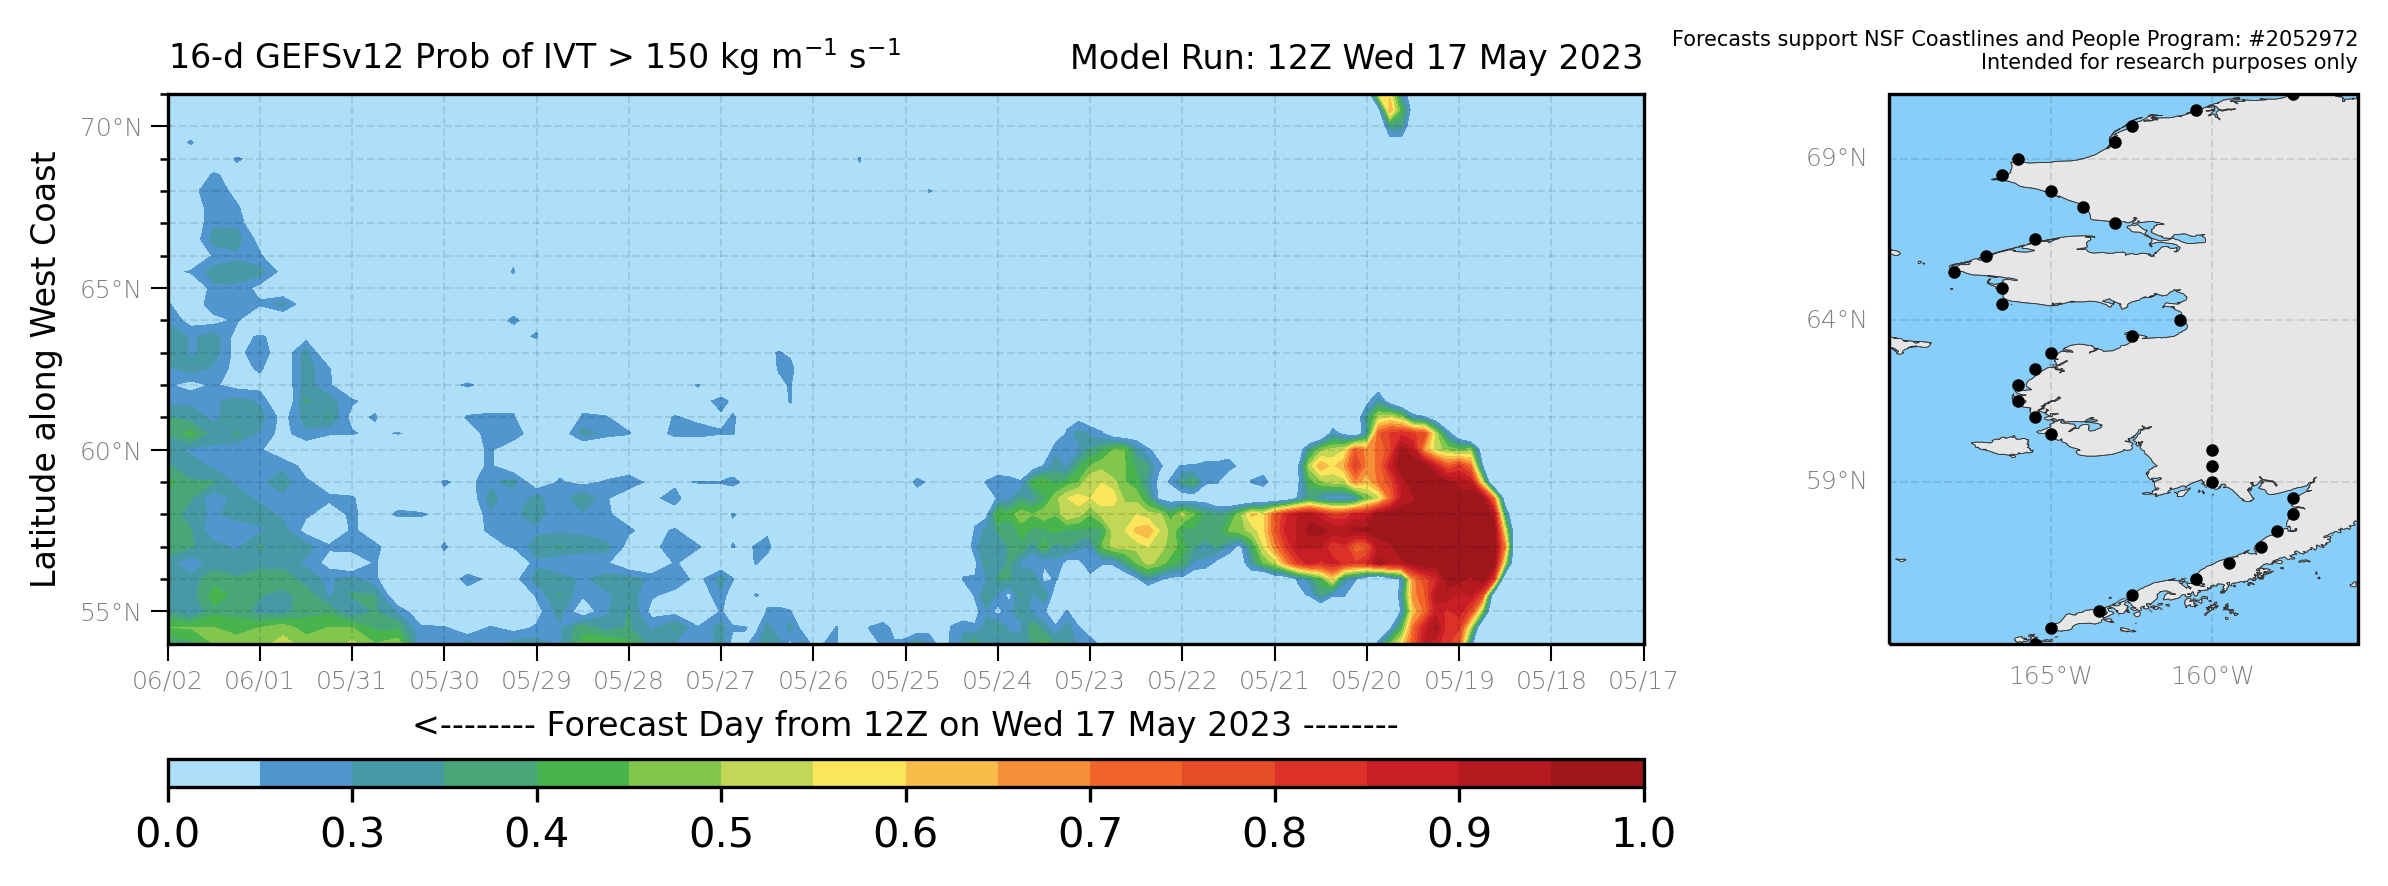

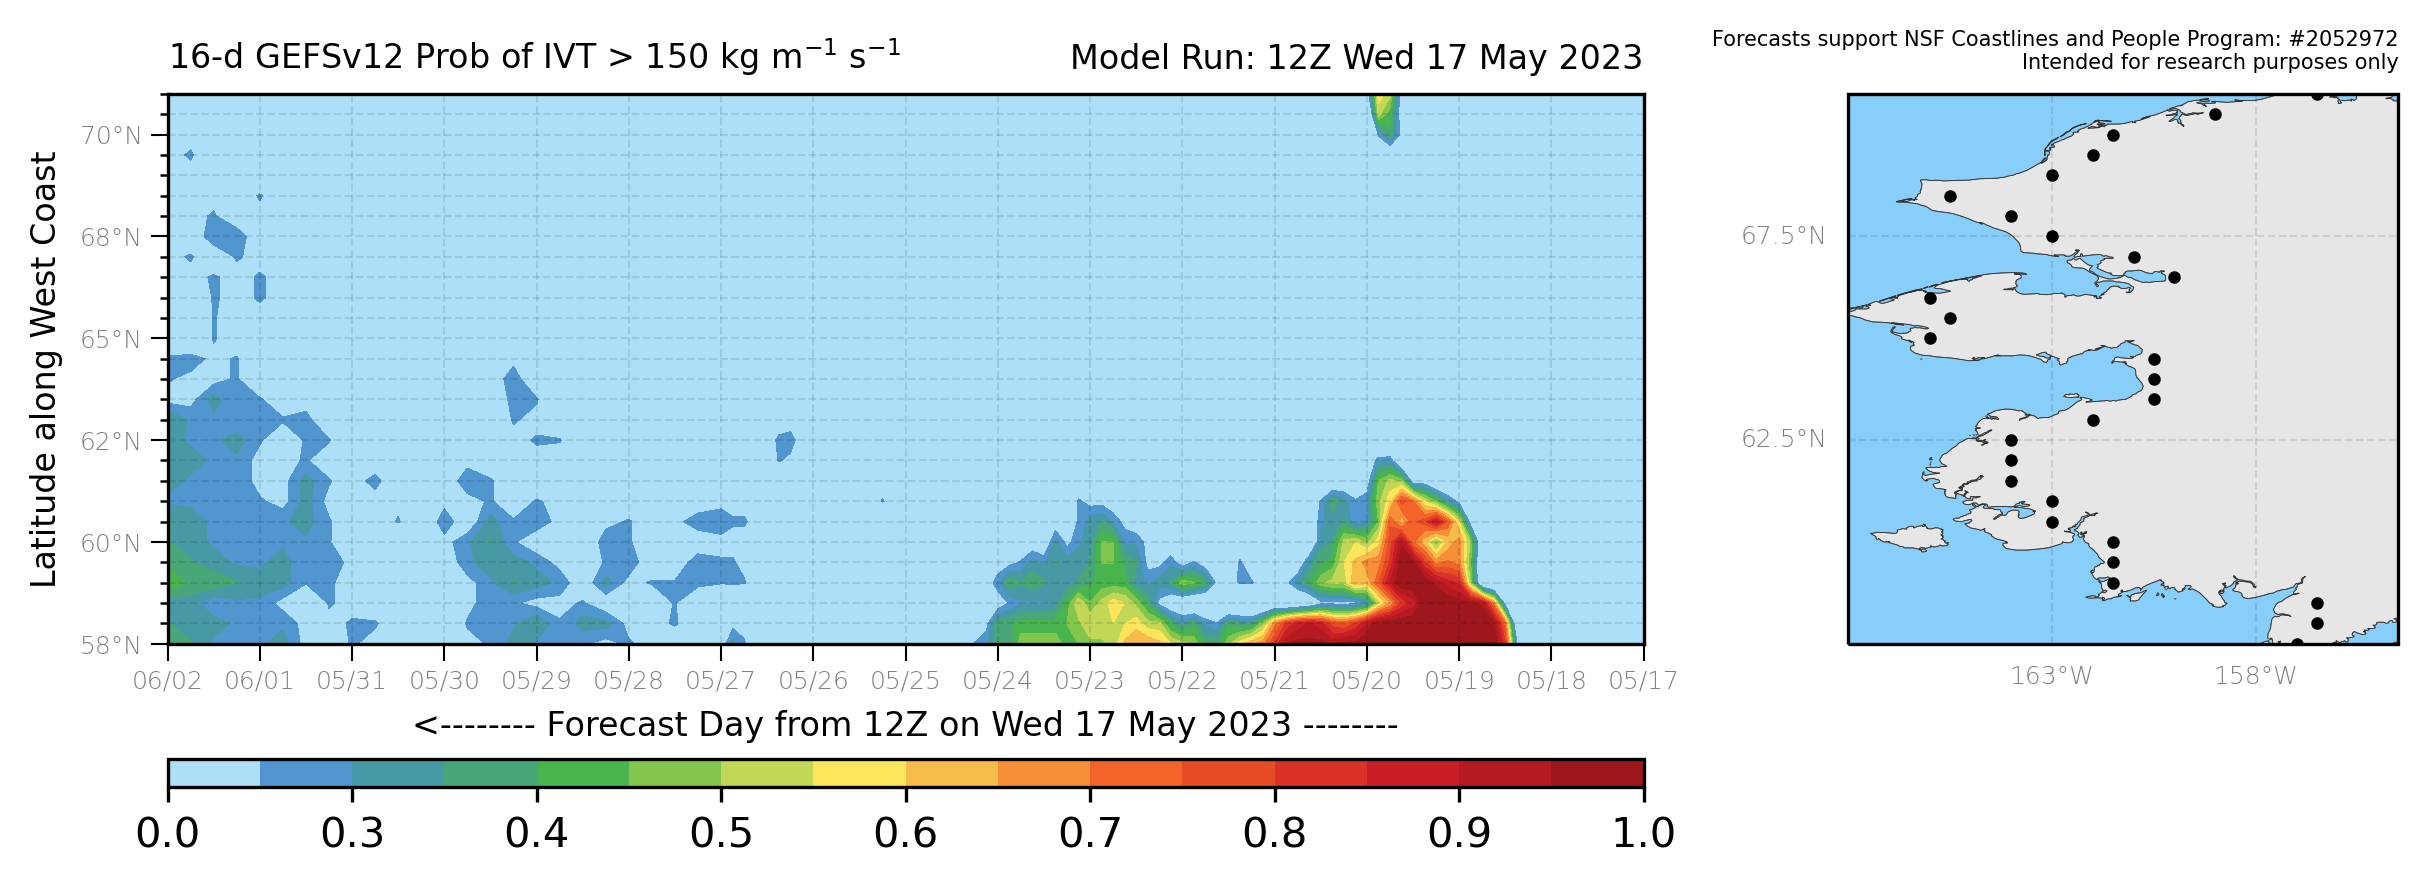

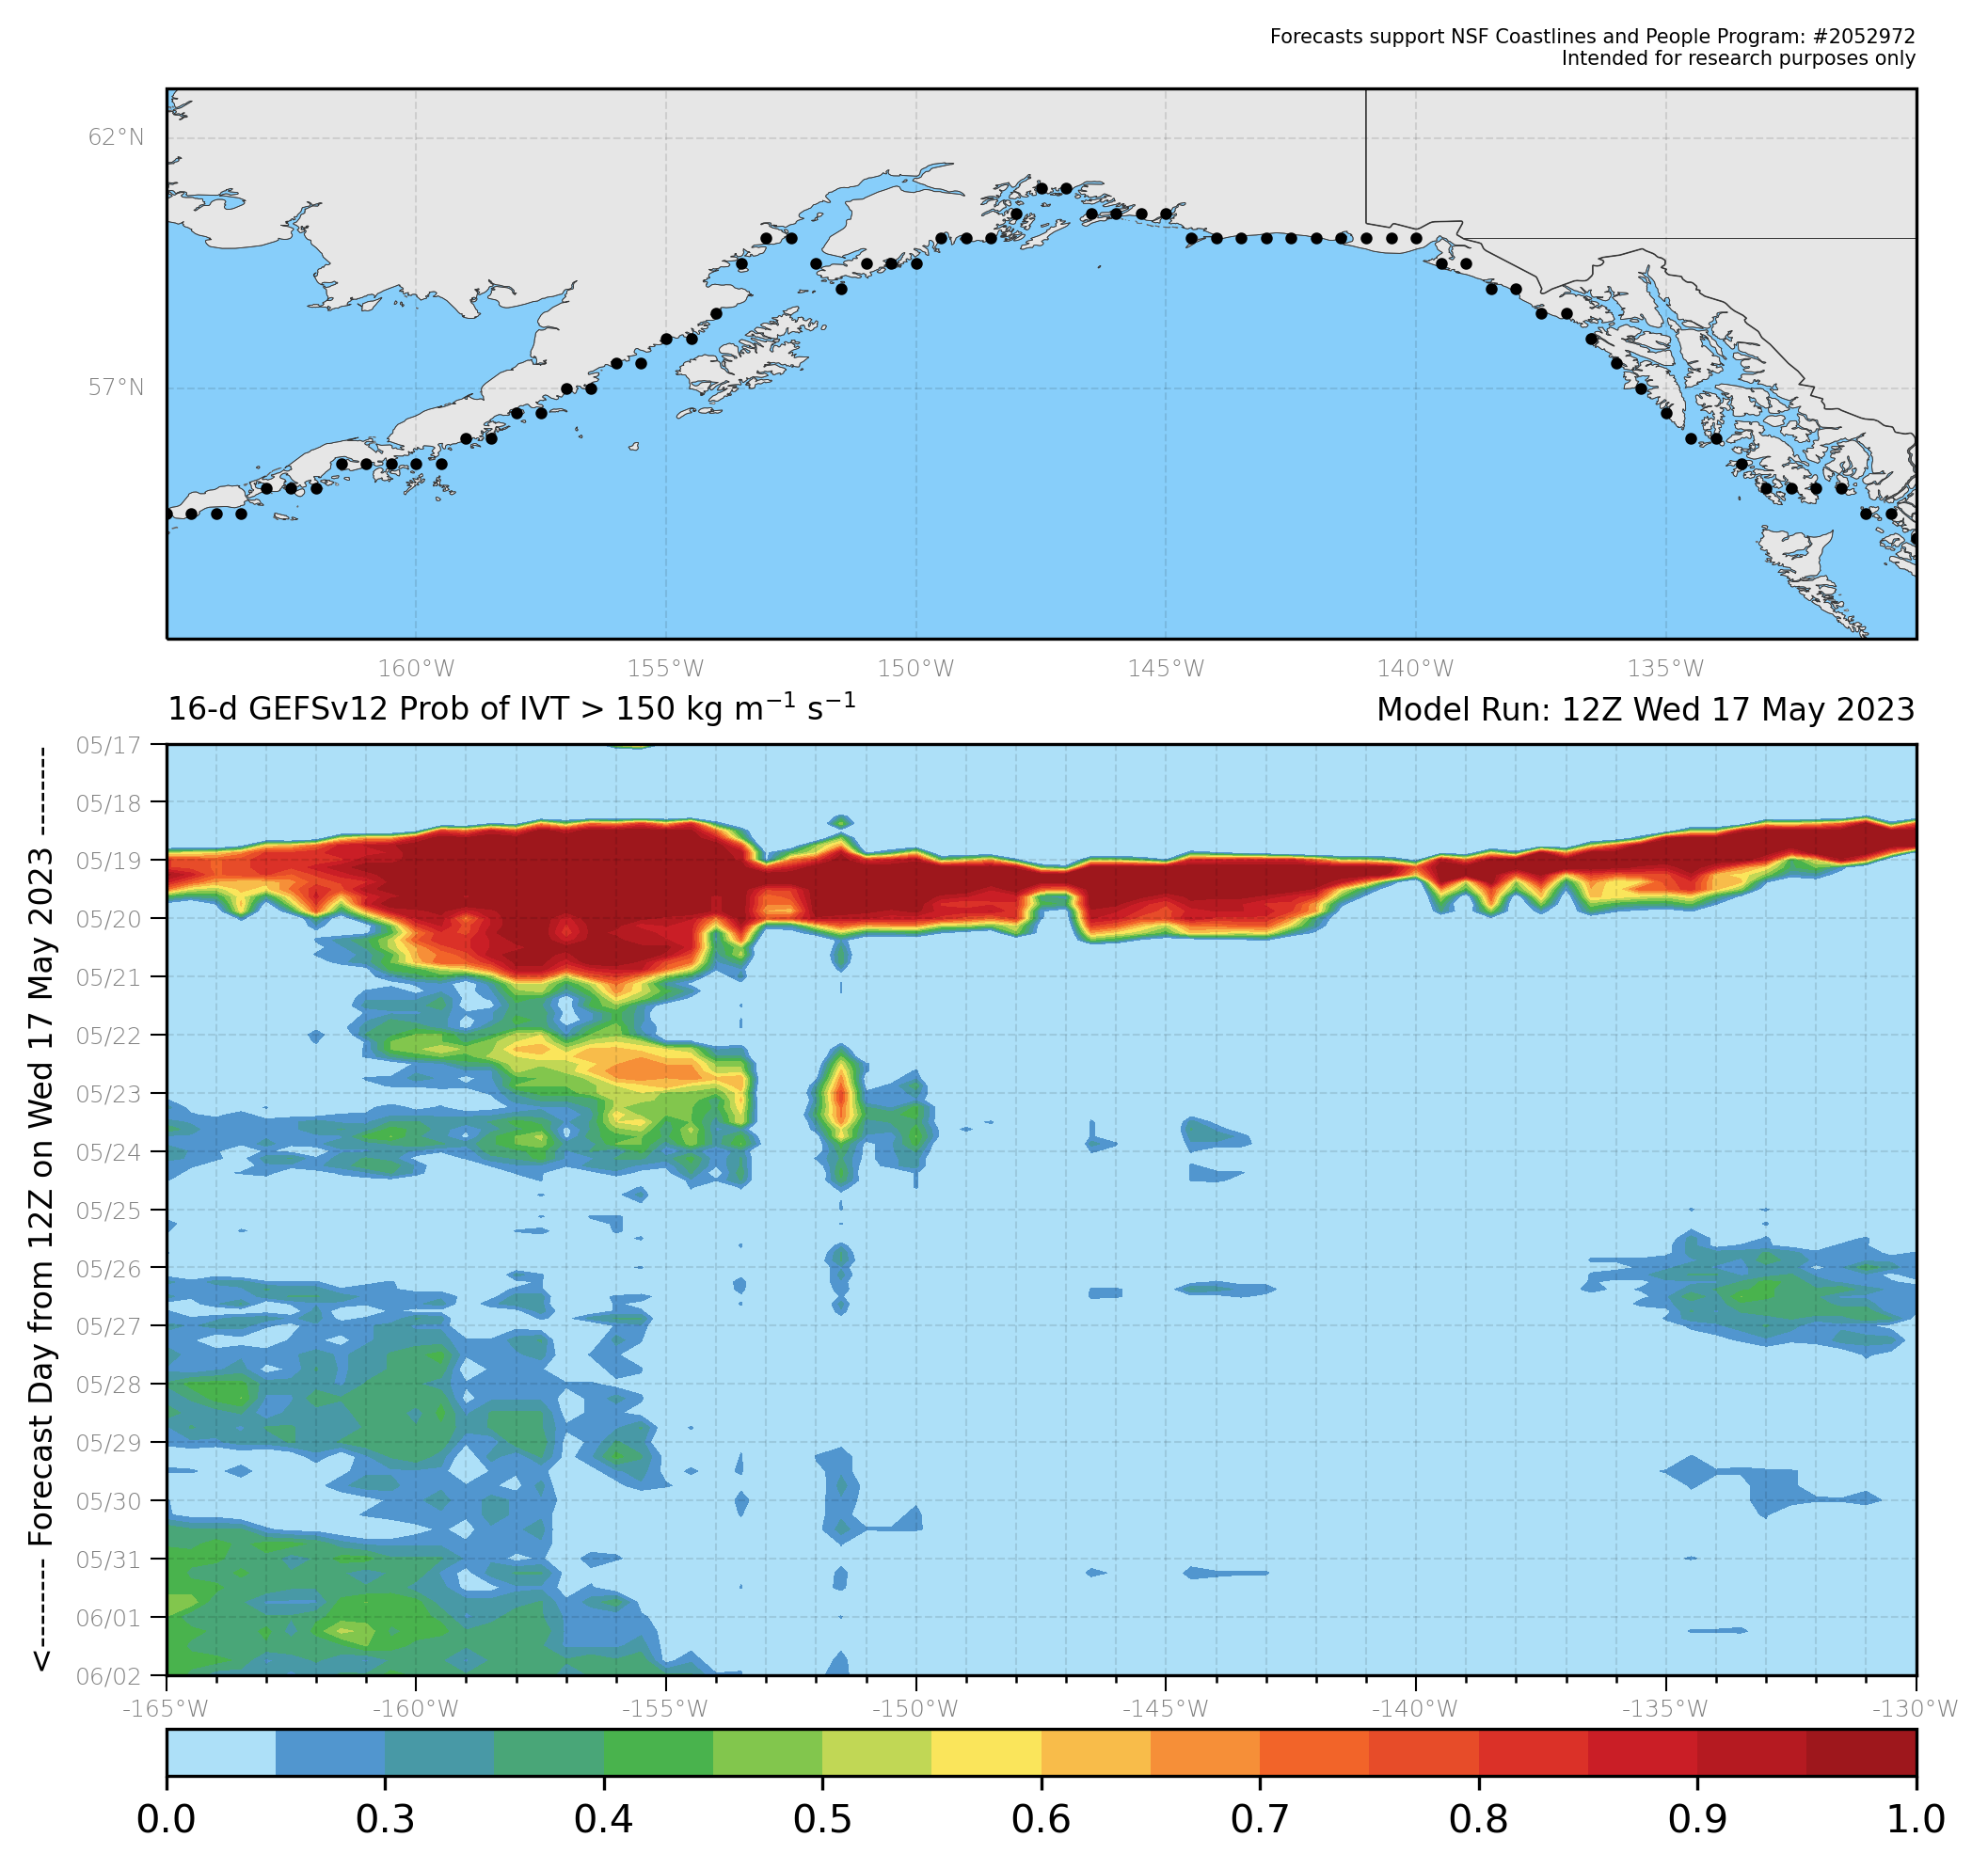

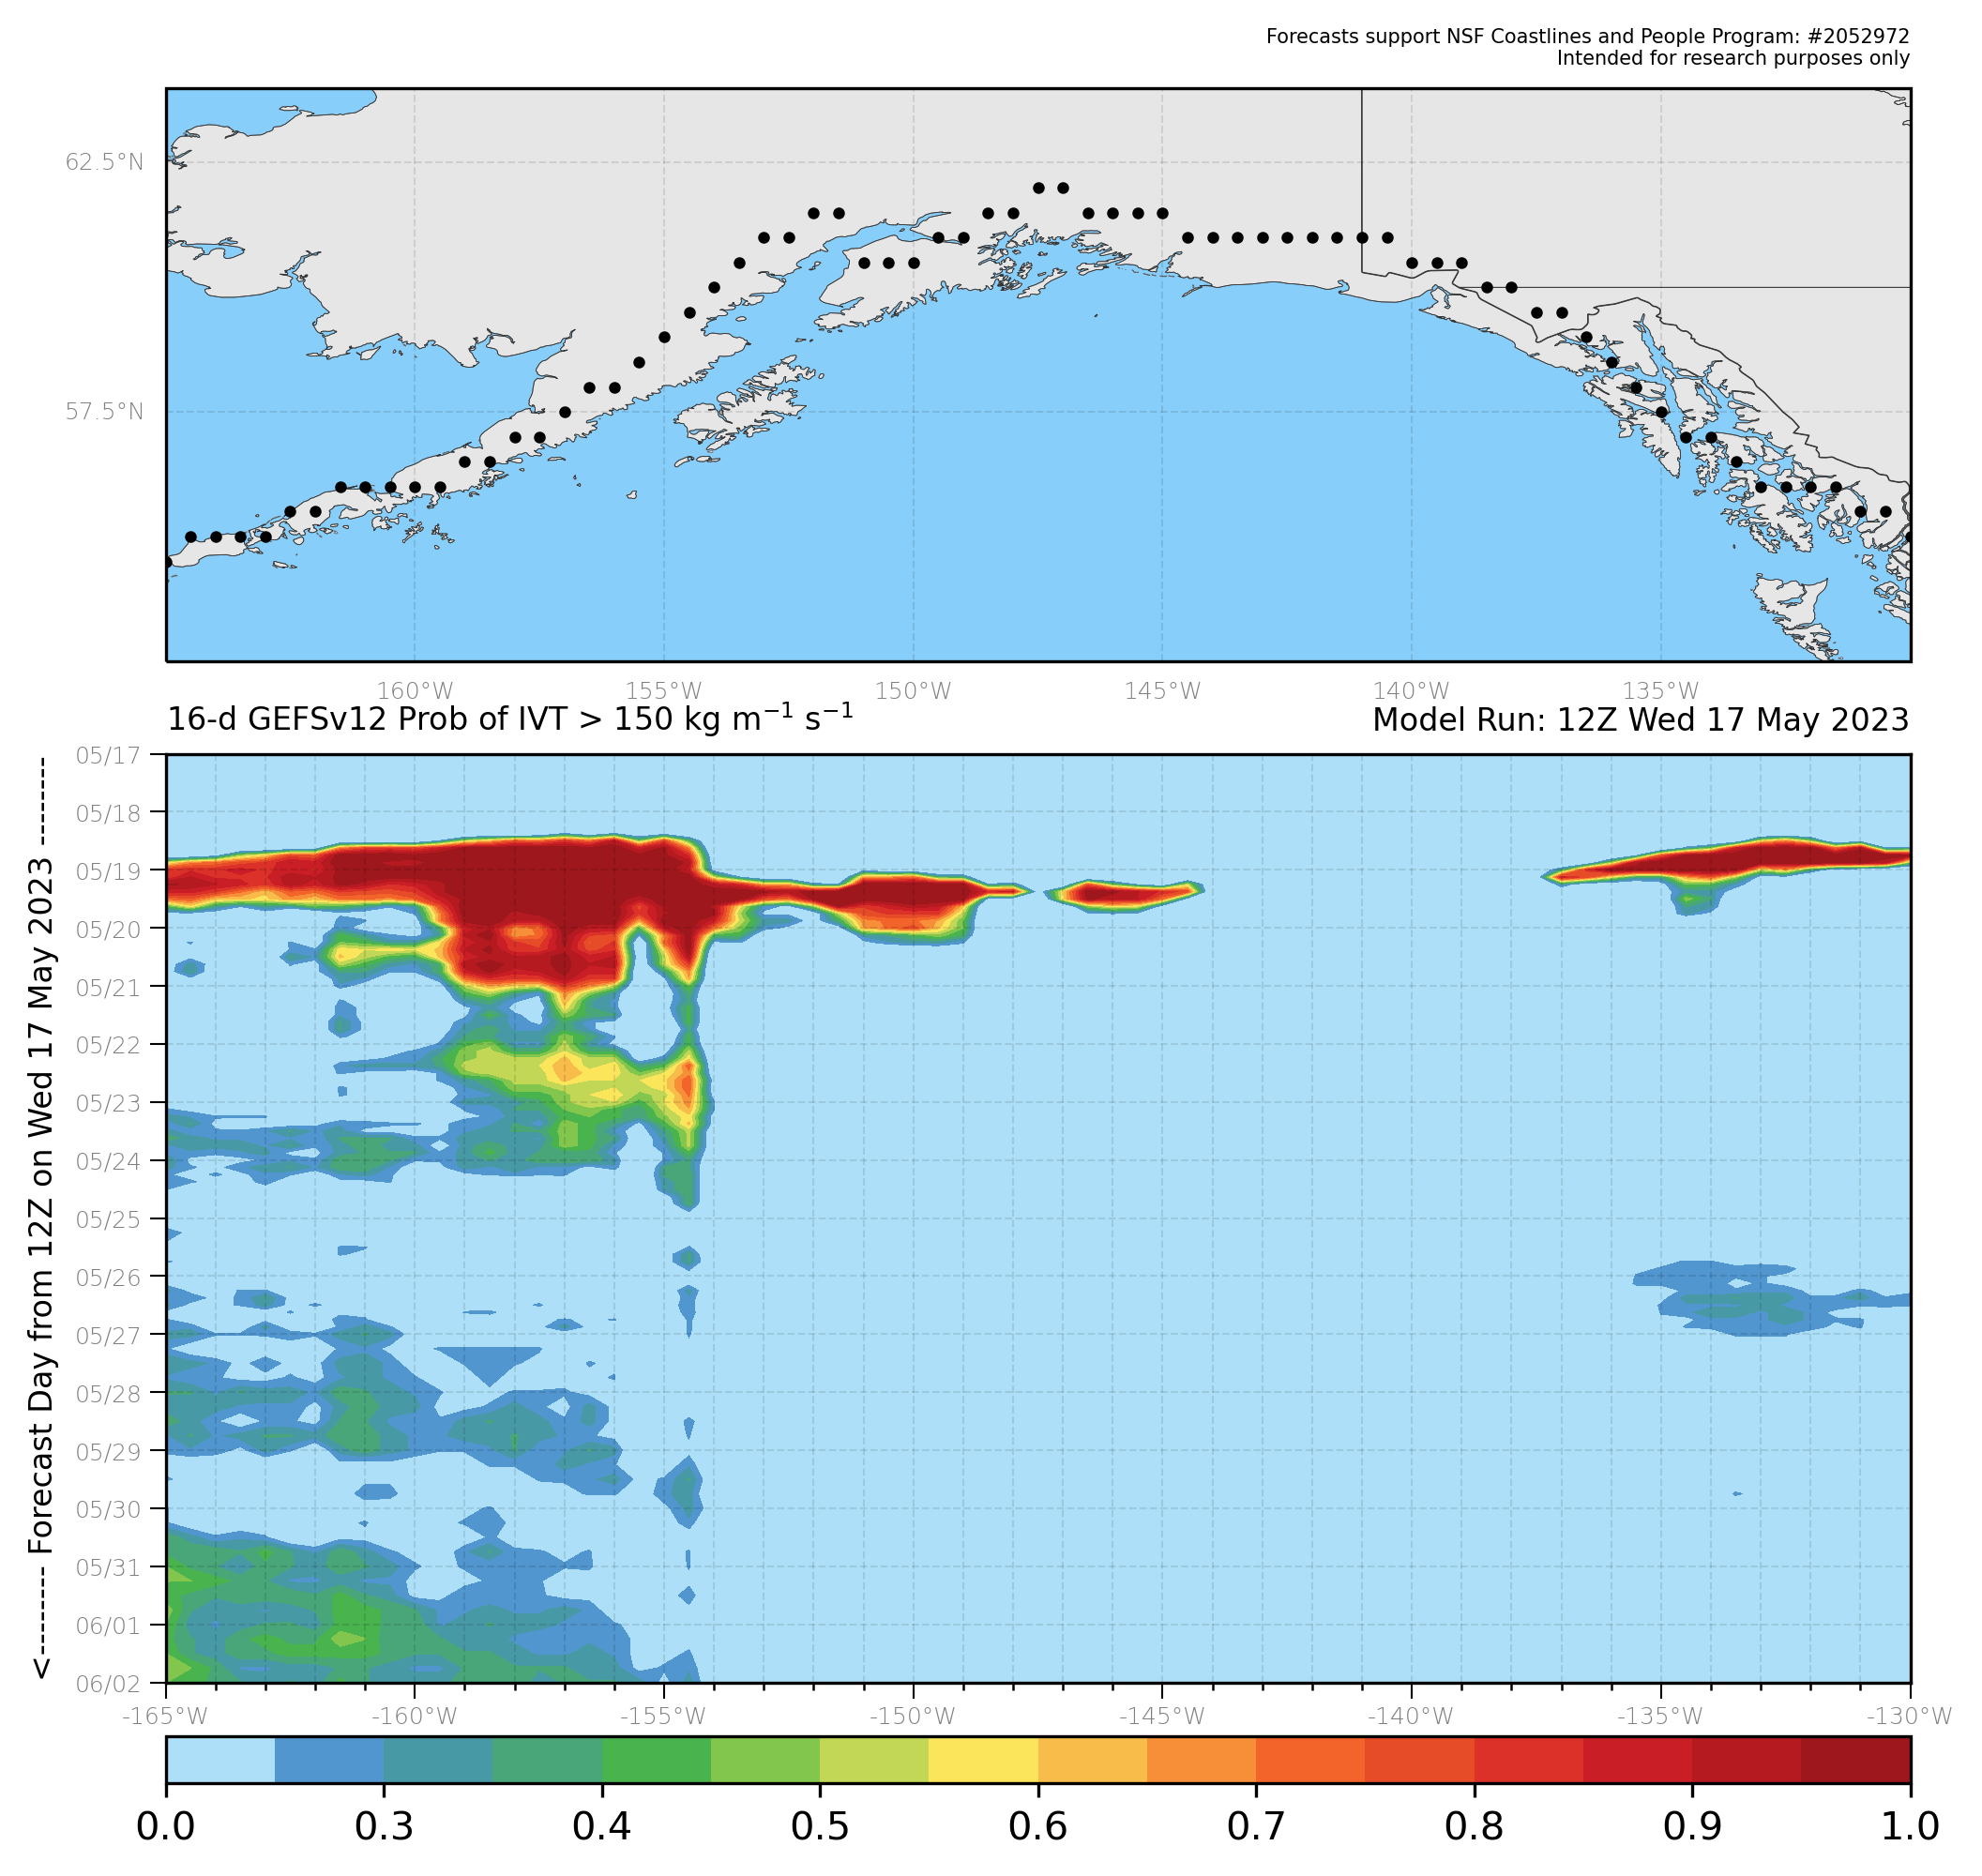

In [5]:
ptloc_lst = ['coast', 'inland']*2
loc_lst = ['AK']*2 + ['SAK']*2
ori_lst = ['latitude']*2 + ['longitude']*2

for i, (ptloc, loc, ori) in enumerate(zip(ptloc_lst, loc_lst, ori_lst)):
    s = waterfall_ivt_probability(loc=loc, ptloc=ptloc, forecast='GEFS', threshold=150, orientation=ori)
    s.create_figure()